# Exploratory Data Analysis
___
### YOK Tez Veri Tabanı | Sosyal ve Beşeri Bilimler Çalışmaları Giriş İncelemesi

Çalışmanın amacı Türkiye'de Sosyal Bilimler alanında yapılmış lisansüstü çalışmalara ilişkin bir metod araştırmasına veri sağlamaktır.
Bu sayfa veriyi tanımak üzere yapılan keşif çalışmasını (EDA | Exploratory Data Analysis) içerir.

1. Veri içeriğinde sosyal bilimler çalışmalarını filtreleyebilecek alanların tespit edilmesi.
2. Elde edilen çalışmalar içerisindeki trendlerin belirlenmesi

In [1]:
#visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
from plotly import graph_objects as go
from plotly.subplots import make_subplots

#analysis & data manuplation
import re
import json
import numpy as np
import pandas as pd
from scipy.io import mmread

In [2]:
#import the data and format the sb
def matrix_reader():
    co_occurrence_matrix = mmread(source="../yoktez/database/whole_matrix.mtx")
    main_df = pd.read_pickle('../yoktez/database/main_db_whole.pickle')
    
    main_df.yıl = pd.to_datetime( main_df.yıl, yearfirst=True, format='%Y' ).dt.year
    #export  the reference word_list from the sb

    main_df['dizin'] = main_df.dizin_tr.loc[main_df.dizin_tr.notna()].str.split(';').apply(lambda x: [i.strip() for i in x])
    dizin = main_df.dizin_tr.loc[main_df.dizin_tr.notna()].str.split(';')

    word_list = list( set( [ kelime.strip() for liste in dizin for kelime in liste ] ) )
    word_list.remove('')
    word_list.sort()

    return co_occurrence_matrix, word_list, main_df
matrix, word_list, df = matrix_reader()

In [3]:
df['enstitü'] = df.enstitü.dropna()
display(df.enstitü.describe())

count                          707279
unique                            226
top        Sosyal Bilimler Enstitüsü 
freq                           232765
Name: enstitü, dtype: object

Enstitüler

,0,1,2,3,4,5,6,7,8,9
0,Adana Numune Eğitim ve Araştırma Hastanesi,Adana Tıp Fakültesi,Adana Şehir Hastanesi,Adli Bilimler Enstitüsü,Adli Tıp Enstitüsü,Adli Tıp Kurumu,Adli Tıp ve Adli Bilimler Enstitüsü,Afet Yönetimi Enstitüsü,Akdeniz Uygarlıkları Araştırma Enstitüsü,Alevilik Araştırmaları Enstitüsü
1,Alparslan Savunma Bilimleri Enstitüsü,Alparslan Savunma Bilimleri ve Milli Güvenlik Enstitüsü,Ankara Atatürk Eğitim ve Araştırma Hastanesi,Ankara Atatürk Göğüs Has. ve Göğ. Cerr.Eğt. ve Arş. Hast.,Ankara Atatürk Sanatoryum Sağlık Uygulama ve Araştırma Merkezi Hastanesi,Ankara Dr. Muhittin Ülker Acil Yard.ve Trav. Eğt. ve Arş. Has.,Ankara Dr. Sami Ulus Çocuk Sağl. ve Has. Eğt. ve Arş. Hast.,Ankara Dışkapı Yıldırım Beyazıt Eğitim Ve Araştırma Hastanesi,Ankara Dışkapı Çocuk Hastalıkları Eğitim Ve Araştırma Hastanesi,Ankara Etlik Zübeyde Hanım Kadın Hastalıkları Eğitim Ve Araştırma Hastanesi
2,Ankara Eğitim ve Araştırma Hastanesi,Ankara Fizik Tedavi Ve Rehabilitasyon Eğitim ve Araştırma Hastanesi,Ankara Keçiören Eğitim ve Araştırma Hastanesi,Ankara Numune Eğitim ve Araştırma Hastanesi,Ankara Refik Saydam Hıfsısıhha Merkezi,Ankara Sağlık Uygulama Ve Araştırma Merkezi,Ankara Türkiye Yüksek İhtisas Eğt. ve Arş. Hastanesi,Ankara Ulucanlar Göz Eğitim ve Araştırma Hastanesi,Ankara Çocuk Sağlığı ve Has. Hematoloji Onkoloji Eğt. Arş. Hastanesi,Ankara Şehir Hastanesi
3,Antalya Eğitim ve Araştırma Hastanesi,Arkeoloji Enstitüsü,Atatürk Stratejik Araştırmalar Enstitüsü,Atatürk Stratejik Araştırmalar ve Lisansüstü Eğitim Enstitüsü,Atatürk İlkeleri ve İnkılap Tarihi Enstitüsü,Avrasya Yerbilimleri Enstitüsü,Avrupa Araştırmaları Enstitüsü,Avrupa Birliği Enstitüsü,Avrupa Birliği Uluslararası İlişkiler Enstitüsü,Bankacılık ve Sigortacılık Enstitüsü
4,Barbaros Deniz Bilimleri ve Mühendisliği Enstitüsü,Bağcılar Eğitim ve Araştırma Hastanesi,Bağımlılık ve Adli Bilimler Enstitü,Başakşehir Çam ve Sakura Şehir Hastanesi,Beyoğlu Göz Sağlık Uygulama Ve Araştırma Merkezi,Bezm-i Alem Vakıf Gureba Hastanesi,Bilişim Enstitüsü,Biyo-Medikal Mühendislik Enstitüsü,Biyonano Teknoloji Enstitüsü,Biyoteknoloji Enstitüsü
5,Bursa Tıp Fakültesi,Bursa Yüksek İhtisas Eğitim ve Araştırma Hastanesi,Bölge Çalışmaları Enstitüsü,Cerrahpaşa Tıp Fakültesi,Deneysel Tıp Araştırma Enstitüsü,Deniz Bilimleri Enstitüsü,Deniz Bilimleri ve Coğrafya Enstitüsü,Deniz Bilimleri ve Mühendisliği Enstitüsü,Deniz Bilimleri ve Teknolojisi Enstitüsü,Deniz Bilimleri ve İşletmeciliği Enstitüsü
6,Deprem Mühendisliği ve Afet Yönetimi Enstitüsü,Diyarbakır Gazi Yaşargil Eğt. ve Arş. Hast.,Diş Hekimliği Fakültesi,Dr. Abdurrahman Yurtaslan Ankara Onkoloji Eğitim ve Araştırma Hastanesi,Dr. Lütfi Kırdar Kartal Eğitim ve Araştırma Hastanesi,Dr. Siyami Ersek Göğüs Kalp ve Damar Cerrahisi Eğitim ve Araştırma Hastanesi,Düzce Tıp Fakültesi,Dış Ticaret Enstitüsü,Eczacılık Fakültesi,Ege Doğumevi ve Kadın Hastalıkları Eğitim ve Araştırma Hastanesi
7,Ekonomi ve Sosyal Bilimler Enstitüsü,Enerji Enstitüsü,Enerji Teknolojileri Enstitüsü,Enformatik Enstitüsü,Erzurum Bölge Eğt. ve Arş. Hast.,Eğitim Bilimleri Enstitüsü,Fen Bilimleri Enstitüsü,Finans Enstitüsü,Gaziosmanpaşa Sağlık Uygulama ve Araştırma Merkezi,Gaziosmanpaşa Taksim Eğitim ve Araştırma Hastanesi
8,Gevher Nesibe Genom ve Kök Hücre Enstitüsü,Göztepe Eğitim ve Araştırma Hastanesi,Göztepe Prof. Dr. Süleyman Yalçın Şehir Hastanesi,Göç Enstitüsü,Gülhane Diş Hekimliği Fakültesi,Gülhane Sağlık Bilimleri Enstitüsü,Gülhane Tıp Fakültesi,Güneş Enerjisi Enstitüsü,Güvenlik Bilimleri Enstitüsü,Güzel Sanatlar Enstitüsü
9,Hacı Bektaş Veli Araştırma ve Uygulama Enstitüsü,Halk Sağlığı Enstitüsü,Hamidiye Sağlık Bilimleri Enstitüsü,Hamidiye Uluslararası Tıp Fakültesi,Havacılık ve Uzay Bilimleri Enstitüsü,Havacılık ve Uzay Teknolojileri Enstitüsü,Haydarpaşa Eğitim Hastanesi,Heybeliada Sanatoryumu Göğüs Hastalıkları ve Göğüs Cerrahisi Eğitim ve Araştırma Hastanesi,Hezarfen Havacılık ve Uzay Teknolojileri Enstitüsü,Kandilli Rasathanesi ve Deprem Araştırma Enstitüsü


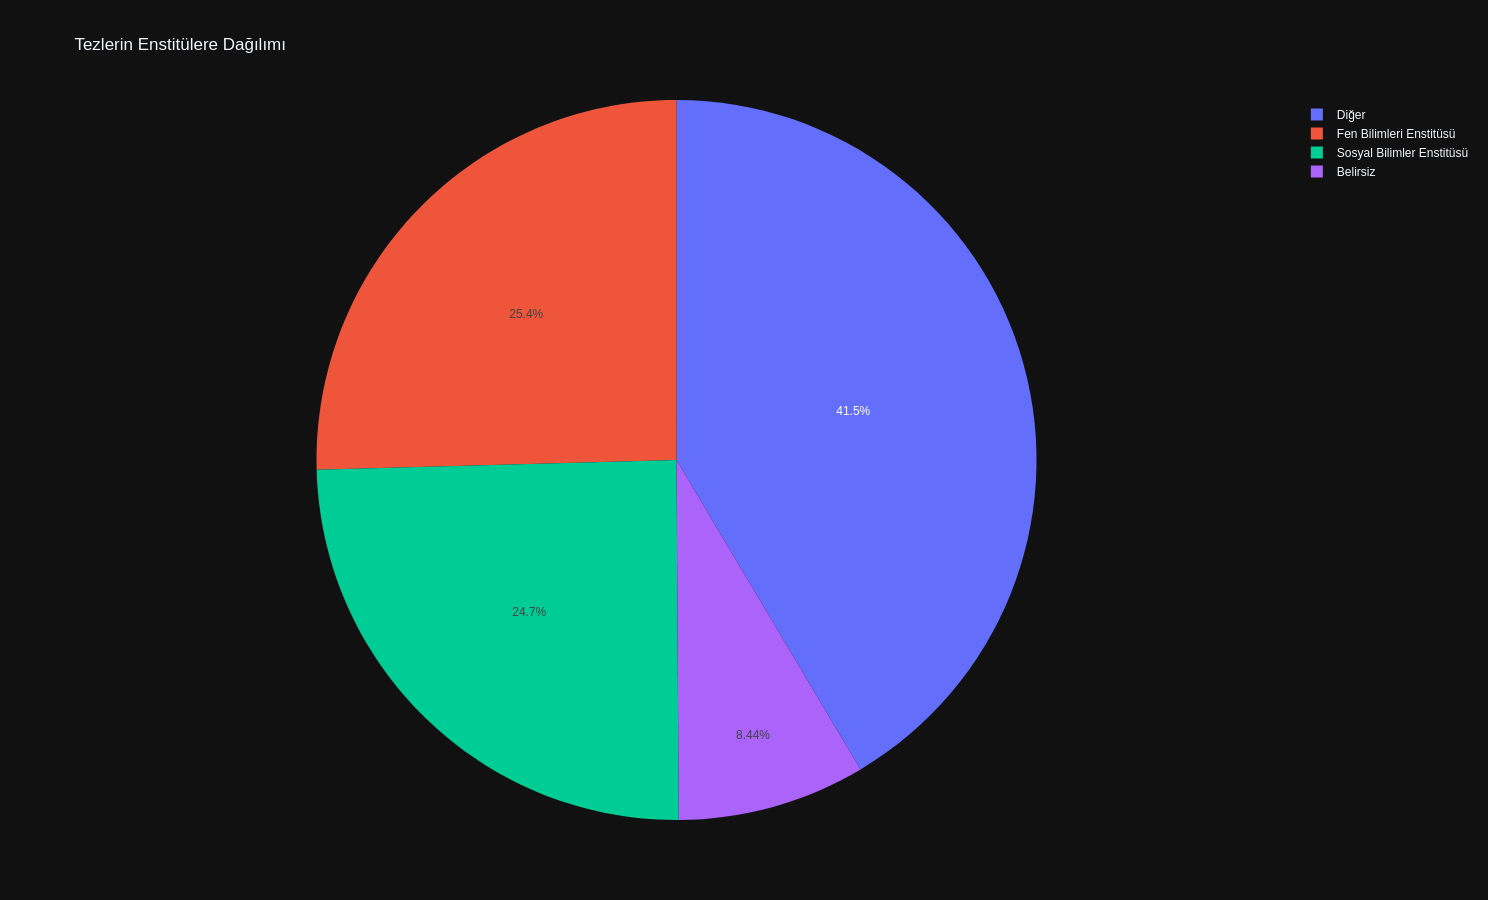

In [9]:
sosyal_bilimler =['Sosyal', 'Beşeri', 'İnsan ve Toplum']
belirsiz = ['Mevlana', 'Medeniyet', 'İslam', 'Türk', 'Lisans', 'Alevi', 'Akdeniz', 'Avrupa', 'Atatürk', 'Bölge', 'Eğitim', 'Tasavvuf']
sb_dışı = ['Hasta', 'Diş','Tıp', 'Hast.','Sağlı','Eczacılık', 'Onkoloji', 'Kanser', 'Hücre', 'Nakl', 'Kardiyo', 'Acil', 'sıhha',
           'Spor','Uzay', 'tıp', 'Biyo','Mühendis','İşletme','İktisat', 'Adli', 'Enerji', 'Savunma', 'Çevre',
           'Matematik','Müzik', 'Fen', 'Yerbilim', 'Nükleer', 'Güneş', 'Deniz', 'Deprem',
           'Prify', 'Hamburg',
           'eknoloji', 'Finans', 'Ticaret', 'Banka', 'Muhasebe',
           'None']

sosyal_bilimler_filtre = df.enstitü.str.contains( '|'.join(sosyal_bilimler), na=False)
belirsiz_filtre = df.enstitü.str.contains( '|'.join(belirsiz), na=False)
sb_dışı_filtre = df.enstitü.str.contains( '|'.join(sb_dışı), na=False)

enstitü_tablosu = pd.DataFrame(np.append( df.enstitü.dropna().sort_values().unique(), ['None']*4 ).reshape(-1,10))
#enstitü_tablosu = pd.DataFrame(enstitü_isimleri.unique().reshape(-1,10))
def color_filter(x):
    if re.compile('|'.join(sb_dışı)).findall(x):
        return 'opacity:30%'
    
    elif re.compile('|'.join(sosyal_bilimler)).findall(x):
        return 'background-color:green'

    else:# re.compile('|'.join(belirsiz)).findall(x):
        return 'color:black;background-color:yellow'

display(enstitü_tablosu.style.applymap(lambda x: color_filter(x) ))

fig = go.Figure()
fig.add_trace(  go.Pie(
    labels=['Sosyal Bilimler Enstitüsü', 'Belirsiz', 'Fen Bilimleri Enstitüsü', 'Diğer'],
    values=[ df.enstitü.loc[sosyal_bilimler_filtre].count(), df.enstitü.loc[belirsiz_filtre].count(), df.enstitü.loc[df.enstitü.str.contains('Fen', na=False)].count(),df.enstitü.loc[sb_dışı_filtre].count()],
    ))
fig.update_layout(template='plotly_dark', width=900, height=900, title='Tezlerin Enstitülere Dağılımı',)
fig.show()


Verileri yalnızca sosyal bilimler enstitülerinden gelen verilere daraltıyoruz.

In [5]:
sb = df.loc[sosyal_bilimler_filtre]

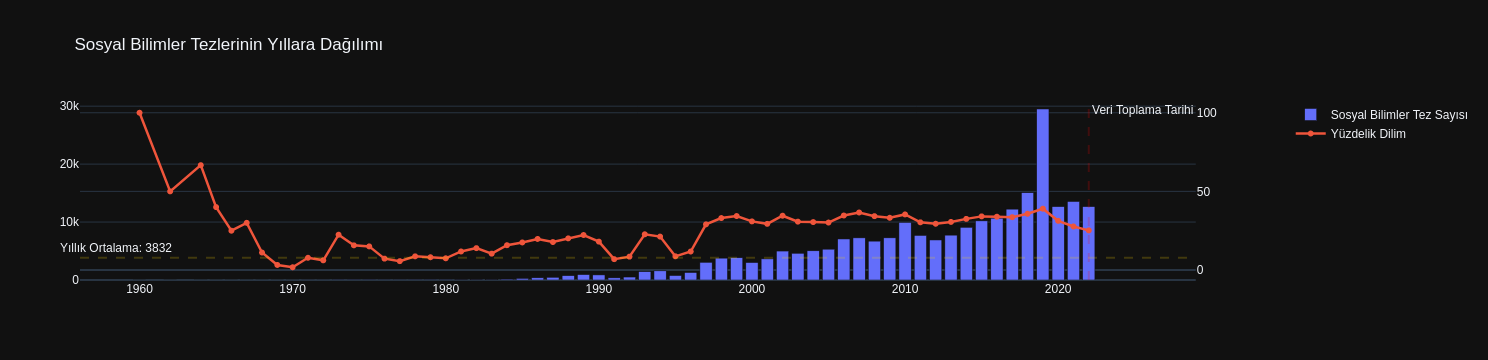

In [8]:
fig = make_subplots(specs=[[{'secondary_y':True}]])
fig.add_bar(x=sb.groupby('yıl')['tez_adı_tr'].agg('count').index, y=sb.groupby('yıl')['tez_adı_tr'].agg('count').values , name='Sosyal Bilimler Tez Sayısı' )
fig.add_scatter(x=sb.groupby('yıl')['tez_adı_tr'].agg('count').index, 
                y=sb.groupby('yıl')['tez_adı_tr'].agg('count').values / df.loc[ (df.yıl<=sb.yıl.max()) & (df.yıl>sb.yıl.min()) ].groupby('yıl')['tez_adı_tr'].agg('count').values *100, 
                secondary_y=True,
                mode='lines+markers', 
                line=dict({'width':2.5, 'smoothing':1.3}), 
                name='Yüzdelik Dilim')
fig.add_vline(x=2022, annotation= go.layout.Annotation(text='Veri Toplama Tarihi' ),  line_dash='dash', opacity=0.2, line_color='red')
fig.add_hline(y=sb.groupby('yıl')['tez_adı_tr'].agg('count').mean(), annotation= go.layout.Annotation(text=f"Yıllık Ortalama: {sb.groupby('yıl')['tez_adı_tr'].agg('count').mean():.0f}" , xref='x', x=0.085),line_dash='dash', opacity=0.2, line_color='gold')
fig.update_layout(title='Sosyal Bilimler Tezlerinin Yıllara Dağılımı', hovermode='x', template='plotly_dark' )
fig.show()

<Axes: xlabel='yıl'>

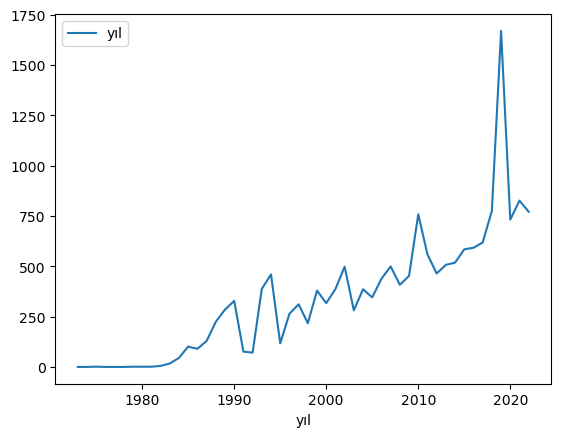

In [10]:
sb.loc[sb['üniversite'].str.contains('İstanbul Üniversitesi')].groupby('yıl').agg({'yıl': 'count'}).plot()